In [2]:
import scipy.io

# import h5py
import torch.nn as nn

import operator
from functools import reduce
from functools import partial
import torch.nn.functional as F
from timeit import default_timer

# from utilities3 import *

import copy
from pathlib import Path
import sys
import os
sys.path.append("..")
os.environ["KMP_DUPLICATE_LIB_OK"] = "True"

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch.optim as optim
from matplotlib.animation import FuncAnimation
from tqdm.auto import tqdm, trange

# sys.path.append("C:/Users/LSY/Desktop/Research/PDE/neural_rk-main/PINN/v1/")
# sys.path.append("C:/Users/LSY/Desktop/Research/PDE/neural_rk-main")
# from dataset import DataDataset, ICDataset, PDEDataset, PeriodicBCDataset
# from loss import bc_derivative_mse, pde_mse
# from model import Model
from preprocess import preprocess

from burgers.plot import plot_2d
from neural_rk.modules import count_trainable_param
from neural_rk.path import DATA_DIR, FIG_DIR

rng = np.random.default_rng(42)
device = torch.device("cuda:0")

torch.manual_seed(0)
np.random.seed(0)

In [2]:
sys.path

['C:\\Users\\LSY\\Desktop\\Research\\PDE\\neural_rk-main\\FNO',
 'D:\\anaconda3\\python311.zip',
 'D:\\anaconda3\\DLLs',
 'D:\\anaconda3\\Lib',
 'D:\\anaconda3',
 '',
 'D:\\anaconda3\\Lib\\site-packages',
 'D:\\anaconda3\\Lib\\site-packages\\win32',
 'D:\\anaconda3\\Lib\\site-packages\\win32\\lib',
 'D:\\anaconda3\\Lib\\site-packages\\Pythonwin',
 'C:/Users/LSY/Desktop/Research/PDE/neural_rk-main/PINN/v1/',
 'C:/Users/LSY/Desktop/Research/PDE/neural_rk-main']

In [3]:
test_id = "IC_train"
sample_idx = 0
exp_id = "PINN"

df = pd.read_pickle(DATA_DIR / f"burgers_{test_id}.pkl")
data = df.iloc[sample_idx]
data

network_type                                              100_100
edge_index      [[tensor(0), tensor(0), tensor(1), tensor(1), ...
node_attr       [[tensor(1.), tensor(1.)], [tensor(1.), tensor...
edge_attr       [[tensor(0.0100), tensor(0.)], [tensor(0.), te...
glob_attr                      [[tensor(0.0100), tensor(0.0100)]]
dts             [[tensor(0.0010)], [tensor(0.0010)], [tensor(0...
trajectories    [[[tensor(-0.3704), tensor(0.7340)], [tensor(-...
Name: 0, dtype: object

In [4]:
xyt, field, nu = preprocess(data)

In [5]:
time = xyt[:, :, :, -1]
t_step = time.unique()
t_step

tensor([0.0000e+00, 1.0000e-03, 2.0000e-03,  ..., 1.9980e+00, 1.9990e+00,
        2.0000e+00])

In [6]:
r_t = 10
t_step_sub = t_step[::r_t]
# t_iter = len(t_step_sub)-1
t_step_sub

tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400, 0.0500, 0.0600, 0.0700, 0.0800,
        0.0900, 0.1000, 0.1100, 0.1200, 0.1300, 0.1400, 0.1500, 0.1600, 0.1700,
        0.1800, 0.1900, 0.2000, 0.2100, 0.2200, 0.2300, 0.2400, 0.2500, 0.2600,
        0.2700, 0.2800, 0.2900, 0.3000, 0.3100, 0.3200, 0.3300, 0.3400, 0.3500,
        0.3600, 0.3700, 0.3800, 0.3900, 0.4000, 0.4100, 0.4200, 0.4300, 0.4400,
        0.4500, 0.4600, 0.4700, 0.4800, 0.4900, 0.5000, 0.5100, 0.5200, 0.5300,
        0.5400, 0.5500, 0.5600, 0.5700, 0.5800, 0.5900, 0.6000, 0.6100, 0.6200,
        0.6300, 0.6400, 0.6500, 0.6600, 0.6700, 0.6800, 0.6900, 0.7000, 0.7100,
        0.7200, 0.7300, 0.7400, 0.7500, 0.7600, 0.7700, 0.7800, 0.7900, 0.8000,
        0.8100, 0.8200, 0.8300, 0.8400, 0.8500, 0.8600, 0.8700, 0.8800, 0.8900,
        0.9000, 0.9100, 0.9200, 0.9300, 0.9400, 0.9500, 0.9600, 0.9700, 0.9800,
        0.9900, 1.0000, 1.0100, 1.0200, 1.0300, 1.0400, 1.0500, 1.0600, 1.0700,
        1.0800, 1.0900, 1.1000, 1.1100, 

In [7]:
field = field[::r_t, :, :, :] # field subsampling
field.shape

torch.Size([201, 101, 101, 2])

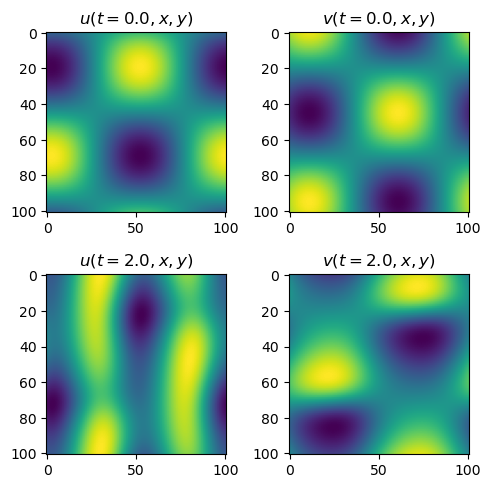

In [8]:
t_init_index = 0
t_final_index = -1
t_init = t_step_sub[t_init_index]
t_final = t_step_sub[t_final_index]
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(2,2,1)
img1 = ax1.imshow(field[t_init_index, :, :, 0])
plt.title(r'$u(t={:.1f},x,y)$'.format(t_init))
ax2 = plt.subplot(2,2,2)
img2 = ax2.imshow(field[t_init_index, :, :, 1])
plt.title(r'$v(t={:.1f},x,y)$'.format(t_init))
ax3 = plt.subplot(2,2,3)
img3 = ax3.imshow(field[t_final_index, :, :, 0])
plt.title(r'$u(t={:.1f},x,y)$'.format(t_final))
ax4 = plt.subplot(2,2,4)
img4 = ax4.imshow(field[t_final_index, :, :, 1])
plt.title(r'$v(t={:.1f},x,y)$'.format(t_final))
plt.tight_layout()
plt.show()

In [9]:
class SpectralConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 # Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        # Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        # Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

In [10]:
class MLP(nn.Module):
    def __init__(self, in_channels, out_channels, mid_channels):
        super(MLP, self).__init__()
        self.mlp1 = nn.Conv2d(in_channels, mid_channels, 1)
        self.mlp2 = nn.Conv2d(mid_channels, out_channels, 1)

    def forward(self, x):
        x = self.mlp1(x)
        x = F.gelu(x)
        x = self.mlp2(x)
        return x

In [11]:
class FNO2d(nn.Module):
    def __init__(self, modes1, modes2,  width):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the coefficient function and locations (u(t, x, y), v(t, x, y), x, y)
        input shape: (batchsize, x=s, y=s, c=4)
        output: the solution u(t+dt, x, y)
        output shape: (batchsize, x=s, y=s, c=2)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
#         self.padding = 9 # pad the domain if input is non-periodic

        self.p = nn.Linear(4, self.width) # input channel is 3: (u(t, x, y), v(t, x, y), x, y)
        self.conv0 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d(self.width, self.width, self.modes1, self.modes2)
        self.mlp0 = MLP(self.width, self.width, self.width)
        self.mlp1 = MLP(self.width, self.width, self.width)
        self.mlp2 = MLP(self.width, self.width, self.width)
        self.mlp3 = MLP(self.width, self.width, self.width)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)
        self.q = MLP(self.width, 2, self.width * 4) # output channel is 2: (u(t+dt, x, y), v(t+dt, x, y))

    def forward(self, x):
        grid = self.get_grid(x.shape, x.device)
        x = torch.cat((x, grid), dim=-1)
        x = self.p(x)
        x = x.permute(0, 3, 1, 2)
#         x = F.pad(x, [0,self.padding, 0,self.padding])

        x1 = self.conv0(x)
        x1 = self.mlp0(x1)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x1 = self.mlp1(x1)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x1 = self.mlp2(x1)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x1 = self.mlp3(x1)
        x2 = self.w3(x)
        x = x1 + x2

#         x = x[..., :-self.padding, :-self.padding]
        x = self.q(x)
        x = x.permute(0, 2, 3, 1)
        return x
    
    def get_grid(self, shape, device):
        batchsize, size_x, size_y = shape[0], shape[1], shape[2]
        gridx = torch.tensor(np.linspace(0, 1, size_x), dtype=torch.float)
        gridx = gridx.reshape(1, size_x, 1, 1).repeat([batchsize, 1, size_y, 1])
        gridy = torch.tensor(np.linspace(0, 1, size_y), dtype=torch.float)
        gridy = gridy.reshape(1, 1, size_y, 1).repeat([batchsize, size_x, 1, 1])
        return torch.cat((gridx, gridy), dim=-1).to(device)

In [12]:
ntrain = int((2001-1)/r_t)
# ntest = int((2001-1)/r_t)

batch_size = 20
learning_rate = 0.001
Num_epochs = 200
iterations = Num_epochs*(ntrain//batch_size)

modes = 16
width = 32

s = 101

In [13]:
x_train = field[:-1, :, :, :]
y_train = field[1:, :, :, :]

# x_test = field[:-1, :, :, :]
# y_test = field[1:, :, :, :]

x_train = x_train.reshape(ntrain,s,s,2)
# x_test = x_test.reshape(ntest,s,s,2)

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)
# test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=batch_size, shuffle=False)

In [14]:
model = FNO2d(modes, modes, width).cuda()
print("The number of parameters: {}".format(count_params(model)))

The number of parameters: 4211618


In [15]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=iterations)
myloss = LpLoss(size_average=False)

x_batch = x_train[:batch_size]
y_pred_batch = model(x_batch.cuda()).reshape(batch_size, s*s*2)
y_batch = y_train[:batch_size].reshape(batch_size, s*s*2)
train_loss_init = myloss(y_pred_batch.cuda(), y_batch.cuda())
print("[Epoch 0], Train loss: {:.4f}".format(train_loss_init / batch_size))   

for epoch in range(1, Num_epochs+1):
    model.train()
    train_loss = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x).reshape(batch_size, s, s, 2)
        out = out.reshape(batch_size, s*s*2)
        y = y.reshape(batch_size, s*s*2)

        loss = myloss(out, y)
        loss.backward()

        optimizer.step()
        scheduler.step()
        train_loss += loss.item()

    train_loss /= ntrain
    
    if epoch % 10 == 0:
        print("[Epoch {}], Train loss: {:.4f}".format(epoch, train_loss))    

[Epoch 0], Train loss: 1.0228
[Epoch 10], Train loss: 0.0546
[Epoch 20], Train loss: 0.0177
[Epoch 30], Train loss: 0.0130
[Epoch 40], Train loss: 0.0083
[Epoch 50], Train loss: 0.0093
[Epoch 60], Train loss: 0.0054
[Epoch 70], Train loss: 0.0071
[Epoch 80], Train loss: 0.0056
[Epoch 90], Train loss: 0.0057
[Epoch 100], Train loss: 0.0046
[Epoch 110], Train loss: 0.0028
[Epoch 120], Train loss: 0.0027
[Epoch 130], Train loss: 0.0027
[Epoch 140], Train loss: 0.0023
[Epoch 150], Train loss: 0.0021
[Epoch 160], Train loss: 0.0018
[Epoch 170], Train loss: 0.0018
[Epoch 180], Train loss: 0.0018
[Epoch 190], Train loss: 0.0017
[Epoch 200], Train loss: 0.0017


In [16]:
t_iter = 10
model.eval()
for i in range(t_iter):
    if i == 0:
        x_input = x_train[0].view(1, s, s, 2)
    else:
        x_input = y_pred
    y_pred = model(x_input.cuda())     

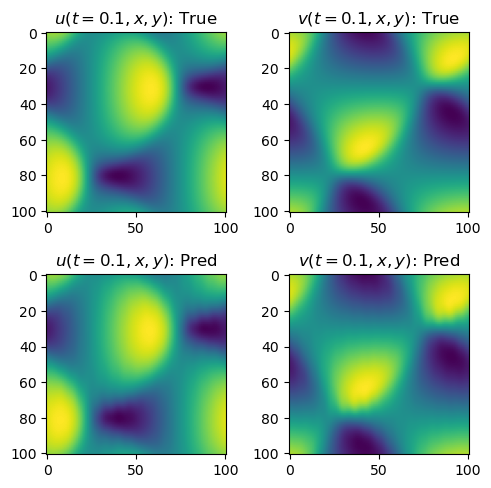

In [17]:
y_pred = y_pred.cpu().detach().numpy()
t_init_index = 0
t_final_index = t_iter
t_init = t_step_sub[t_init_index]
t_final = t_step_sub[t_final_index]
fig = plt.figure(figsize=(5,5))
ax1 = plt.subplot(2,2,1)
img1 = ax1.imshow(y_train[t_final_index, :, :, 0])
plt.title(r'$u(t={:.1f},x,y)$: True'.format(t_final))
ax2 = plt.subplot(2,2,2)
img2 = ax2.imshow(y_train[t_final_index, :, :, 1])
plt.title(r'$v(t={:.1f},x,y)$: True'.format(t_final))
ax3 = plt.subplot(2,2,3)
img3 = ax3.imshow(y_pred[0, :, :, 0])
plt.title(r'$u(t={:.1f},x,y)$: Pred'.format(t_final))
ax4 = plt.subplot(2,2,4)
img4 = ax4.imshow(y_pred[0, :, :, 1])
plt.title(r'$v(t={:.1f},x,y)$: Pred'.format(t_final))
plt.tight_layout()
plt.show()

In [18]:
pred_trajectory = y_pred
true_trajectory = field[t_final_index, :, :, :].cpu().numpy()
true_trajectory = true_trajectory.reshape(1, s, s, 2)

error = true_trajectory - pred_trajectory
print(f"MAE={np.abs(error).mean():.4e}, in range {error.min(), error.max()}")

MAE=3.9205e-03, in range (-0.03195098, 0.0338206)
